# Pertemuan I

Pada praktikum ini, Anda akan melakukan beberapa operasi dasar statistik dengan data bertema keseshatan yaitu data tumor. 

* [Histogram](#1)
* [Outliers](#2)
* [Box Plot ](#3)
* [Summary Statistics](#4)
* [CDF](#5)
* [Effect size](#6)
* [Relationship Between Variables](#7)
* [Correlation](#8)
* [Covariance](#9)
* [Pearson Correlation](#10)
* [Spearman's Rank Correlation](#11)
* [Mean VS Median](#12)
* [Hypothesis Testing](#13)
* [Normal(Gaussian) Distribution and z-score](#14) 


# Instruksi Tugas Praktikum FIKTI dan FTI

1. Silahkan modifikasi kode operasi yang ada menggunakan library perhitungan berbasis GPU (Library Cupy)
2. Jelaskan apakah terdapat korelasi antara variabel atau fitur compactness_mean dengan concavity_mean
3. Buatlah diagram korelasi dari fitur compactness_mean dengan concavity_mean
4. Hitung nilai covariance dari fitur compactness_mean dengan concavity_mean. Jelaskan arti dari nilai tersebut.
5. Hitung nilai pearson correlation dari fitur compactness_mean dengan concavity_mean. Jelaskan arti dari nilai tersebut.
6. Lakukan uji hipotesis untuk kolom fitur compactness_mean dengan concavity_mean yang berbeda serta berikan penjelasan terhadap hasil dari uji hipotesis yang dilakukan. 

# Instruksi Tugas Praktikum Prodi Mesin, FK, FTSP dan Farmasi

1. Lakukan perhitungan summary nilai statistik (mean, standar deviasi, dan variance) dari fitur texture_mean
2. Berdasarkan hasil ploting diagram heatmap, jelaskan korelasi yang ada antara fitur compactness_se dan fractal_dimension_se
3. Hitung nilai pearson correlation dari fitur compactness_se dan fractal_dimension_se. Jelaskan arti dari nilai tersebut.
4. Lakukan uji hipotesis untuk kolom fitur compactness_se dan fractal_dimension_se yang berbeda serta berikan penjelasan terhadap hasil dari uji hipotesis yang dilakukan. 

In [5]:
# import libraries
import pandas as pd
import numpy as np
import cupy as cp
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from scipy import stats
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")
from scipy import stats



In [6]:
# read data as pandas data frame
url_data = "https://raw.githubusercontent.com/supasonicx/ATA-praktikum-01/main/data.csv"
data = pd.read_csv(url_data)
data = data.drop(['Unnamed: 32','id'],axis = 1)

### Overview Dataset

In [7]:
## Melihat 5 baris awal dari dataset yang digunakan
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Note:
---
kolom/field diagnosis : 
* M(malignant)   = Tumor Ganas
* Beningn(Jinak) = Tumor Jinak

In [8]:
##
data.shape

(569, 31)

In [9]:
data.columns 

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

<a id="1"></a> <br>
## Histogram

* Menampilkan Berapa kali (frekueni) setiap nilai muncul dalam kumpulan data. 
* Jenis deskripsi ini disebut distribusi variabel
* Cara paling umum untuk merepresentasikan distribusi variabel adalah histogram yaitu grafik yang menunjukkan frekuensi dari setiap nilai.
* Frequency = berapa kali setiap nilai muncu
* Contoh: [1,1,1,1,2,2,2]. Frequency dari 1 adalah empat dan frequency dari 2 adalah tiga.

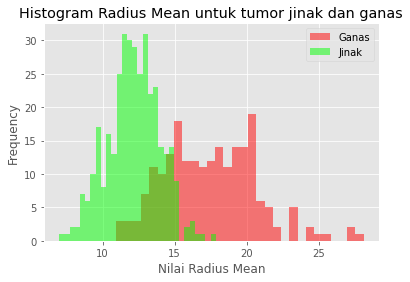

Rata-rata radius ganas yang paling sering adalah:  20.101999999999997


In [10]:
## ploting untuk data tumor dengan label ganas
m = plt.hist(data[data["diagnosis"] == "M"].radius_mean,bins=30,fc = (1,0,0,0.5),label = "Ganas")
## ploting untuk data tumor dengan label jinak
b = plt.hist(data[data["diagnosis"] == "B"].radius_mean,bins=30,fc = (0,1,0,0.5),label = "Jinak")
plt.legend()
plt.xlabel("Nilai Radius Mean")
plt.ylabel("Frequency")
plt.title("Histogram Radius Mean untuk tumor jinak dan ganas")
plt.show()
frequent_malignant_radius_mean = m[0].max()
index_frequent_malignant_radius_mean = list(m[0]).index(frequent_malignant_radius_mean)
most_frequent_malignant_radius_mean = m[1][index_frequent_malignant_radius_mean]
print("Rata-rata radius ganas yang paling sering adalah: ",most_frequent_malignant_radius_mean)

* Mari kita lihat kesimpulan lainnya
* Dari grafik ini terlihat bahwa rata-rata radius tumor ganas lebih besar dari rata-rata radius tumor jinak kebanyakan.
* Sebaran jinak (dalam grafik hijau) kira-kira berbentuk lonceng yaitu bentuk sebaran normal (distribusi gaussian)
* Anda juga dapat menemukan hasil seperti berapa rata-rata radius ganas yang paling sering 

<a id="2"></a> <br>
## Outliers
* Saat melihat histogram seperti yang Anda lihat, ada nilai langka dalam distribusi jinak (grafik hijau)
* Nilai yang ada bisa berupa kesalahan atau kejadian langka.
* Kesalahan dan kejadian langka ini bisa disebut outlier.
* Menghitung outlier: 
    * pertama kita perlu menghitung kuartil pertama (Q1)(25%)
    * kemudian temukan IQR(inter quartile range) = Q3-Q1
    * terakhir menghitung Q1 - 1.5*IQR dan Q3 + 1.5*IQR
    * Apa pun di luar kisaran ini adalah outlier
    * mari kita tulis kode untuk distribusi tumor jinak untuk rata-rata fitur radius

In [11]:
data_jinak = data[data["diagnosis"] == "B"]
data_ganas = data[data["diagnosis"] == "M"]
desc = data_jinak.radius_mean.describe()
Q1 = desc[4]
Q3 = desc[6]
IQR = Q3-Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
print("Apa pun di luar kisaran ini adalah outlier: (", lower_bound ,",", upper_bound,")")
data_jinak[data_jinak.radius_mean < lower_bound].radius_mean
print("Outliers: ",data_jinak[(data_jinak.radius_mean < lower_bound) | (data_jinak.radius_mean > upper_bound)].radius_mean.values)

Apa pun di luar kisaran ini adalah outlier: ( 7.645000000000001 , 16.805 )
Outliers:  [ 6.981 16.84  17.85 ]


<a id="3"></a> <br>
## Box Plot 
* Anda dapat melihat outlier juga dari box plot
* Kita menemukan 3 outlier pada mean/rata-rata radius jinak dan pada box plot terdapat 3 outlier.

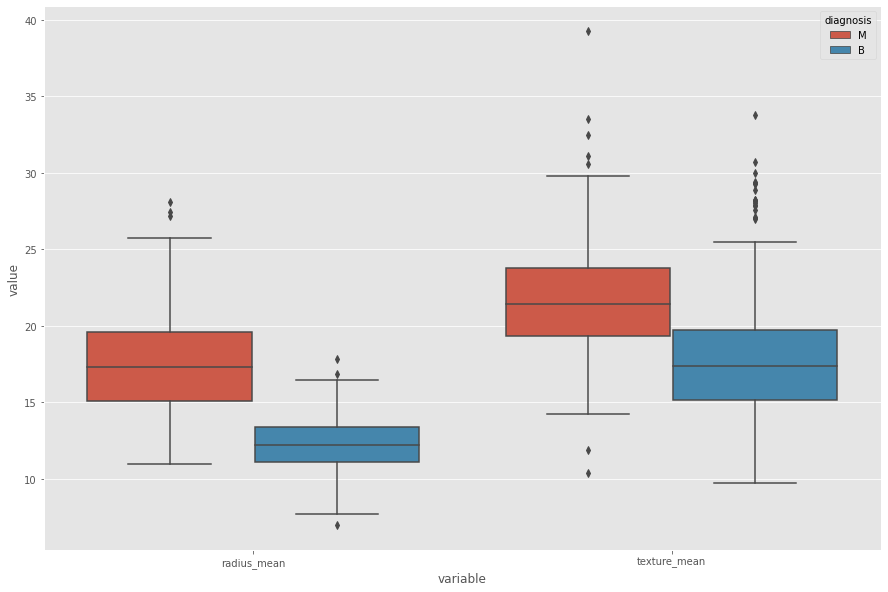

In [12]:
melted_data = pd.melt(data,id_vars = "diagnosis",value_vars = ['radius_mean', 'texture_mean'])
plt.figure(figsize = (15,10))
sns.boxplot(x = "variable", y = "value", hue="diagnosis",data= melted_data)
plt.show()

<a id="4"></a> <br>
## Summary Statistics
* Mean/rata-rata
* Variance: penyebaran distribusi
* Standart deviation square root dari variance
* Mari kita lihat ringkasan statistik rata-rata pancaran tumor jinak:

In [13]:
print("mean: ",data_jinak.radius_mean.mean())
print("variance: ",data_jinak.radius_mean.var())
print("standart deviation (std): ",data_jinak.radius_mean.std())
print("describe method: ",data_jinak.radius_mean.describe())

mean:  12.14652380952381
variance:  3.170221722043872
standart deviation (std):  1.7805116461410389
describe method:  count    357.000000
mean      12.146524
std        1.780512
min        6.981000
25%       11.080000
50%       12.200000
75%       13.370000
max       17.850000
Name: radius_mean, dtype: float64


<a id="5"></a> <br>
## Cummulative Distribution Function
* Fungsi distribusi kumulatif adalah probabilitas bahwa variabel mengambil nilai kurang dari atau sama dengan x. P(X <= x)
* Mari kita jelaskan dalam grafik cdf mean radius jinak
* dalam grafik, berapa P(12 < X)? Jawabannya adalah 0,5. Probabilitas bahwa variabel mengambil nilai kurang dari atau sama dengan 12 (radius mean) adalah 0,5.
* Anda dapat memplot cdf dengan dua metode berbeda

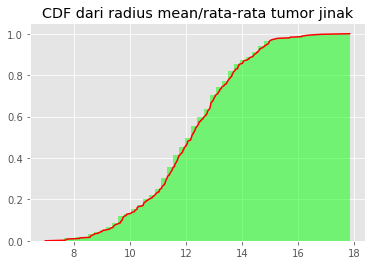

In [14]:
plt.hist(data_jinak.radius_mean,bins=50,fc=(0,1,0,0.5),label='Jinak',density=True, cumulative = True)
sorted_data = cp.sort(data_jinak.radius_mean)
y = cp.arange(len(sorted_data))/float(len(sorted_data)-1)
plt.plot(sorted_data,y,color='red')
plt.title('CDF dari radius mean/rata-rata tumor jinak')
plt.show()

<a id="6"></a> <br>
## Effect size
* Salah satu ringkasan statistik.
* Ini menggambarkan ukuran efek/effect size. Ini adalah cara sederhana untuk mengukur perbedaan antara dua kelompok.
* Dengan kata lain, ukuran efek menekankan ukuran perbedaan
* Gunakan ukuran efek kohen/cohen
* Cohen menyarankan bahwa jika d(ukuran efek)= 0,2, itu adalah ukuran efek kecil, d = 0,5 ukuran efek sedang, d = 0,8 ukuran efek besar.
* mari kita bandingkan ukuran efek antara mean radius jinak dan mean radius ganas
* Ukuran efek adalah 2.2 dan itu terlalu besar dan dikatakan bahwa dua kelompok itu berbeda satu sama lain seperti yang kita harapkan. Karena kelompok kita adalah mean radius jinak dan mean radius ganas yang berbeda satu sama lain

In [15]:
mean_diff = data_ganas.radius_mean.mean() - data_jinak.radius_mean.mean()
var_bening = data_jinak.radius_mean.var()
var_malignant = data_ganas.radius_mean.var()
var_pooled = (len(data_jinak)*var_bening +len(data_ganas)*var_malignant ) / float(len(data_jinak)+ len(data_ganas))
effect_size = mean_diff/cp.sqrt(var_pooled)
print("Effect size: ",effect_size)

Effect size:  2.2048585165041428


<a id="7"></a> <br>
## Relationship Between Variables
* Kita dapat mengatakan bahwa dua variabel terkait satu sama lain, jika salah satunya memberikan informasi tentang yang lain
* Misalnya, harga dan jarak. Jika Anda pergi jarak jauh dengan taksi Anda akan membayar lebih. Oleh karena itu kita dapat mengatakan bahwa harga dan jarak berhubungan positif satu sama lain.
* Scatter Plot, Cara termudah untuk memeriksa hubungan antara dua variabel
* Mari kita lihat hubungan antara radius mean dan mean area
* Di scatter plot Anda dapat melihat bahwa ketika radius mean meningkat, mean area juga meningkat. Oleh karena itu, mereka berkorelasi positif satu sama lain.
* Tidak ada korelasi antara mean area dan dimensi fraktal se. Karena ketika mean area berubah, dimensi fraktal se tidak terpengaruh oleh peluang mean area

<Figure size 1080x720 with 0 Axes>

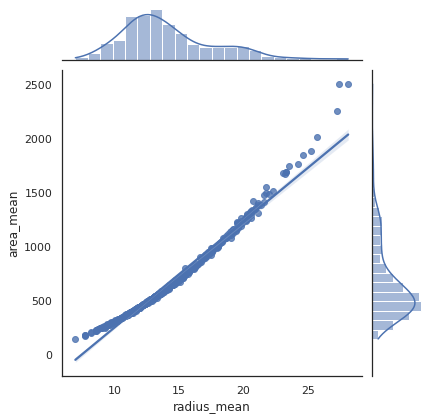

In [21]:
plt.figure(figsize = (15,10))
sns.jointplot(data.radius_mean,data.area_mean,kind="reg")
plt.show()

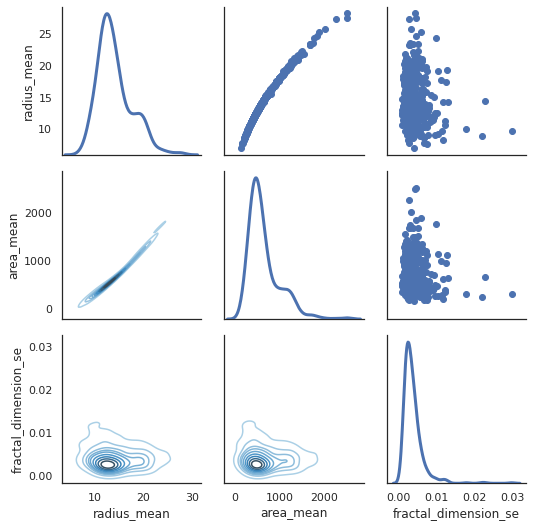

In [17]:
# dan juga kita dapat melihat hubungan antara lebih dari 2 distribusi
sns.set(style = "white")
df = data.loc[:,["radius_mean","area_mean","fractal_dimension_se"]]
g = sns.PairGrid(df,diag_sharey = False,)
g.map_lower(sns.kdeplot,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,lw =3)
plt.show()

<a id="8"></a> <br>
## Correlation
* Kekuatan hubungan antara dua variabel
* Mari kita lihat korelasi antara semua fitur.

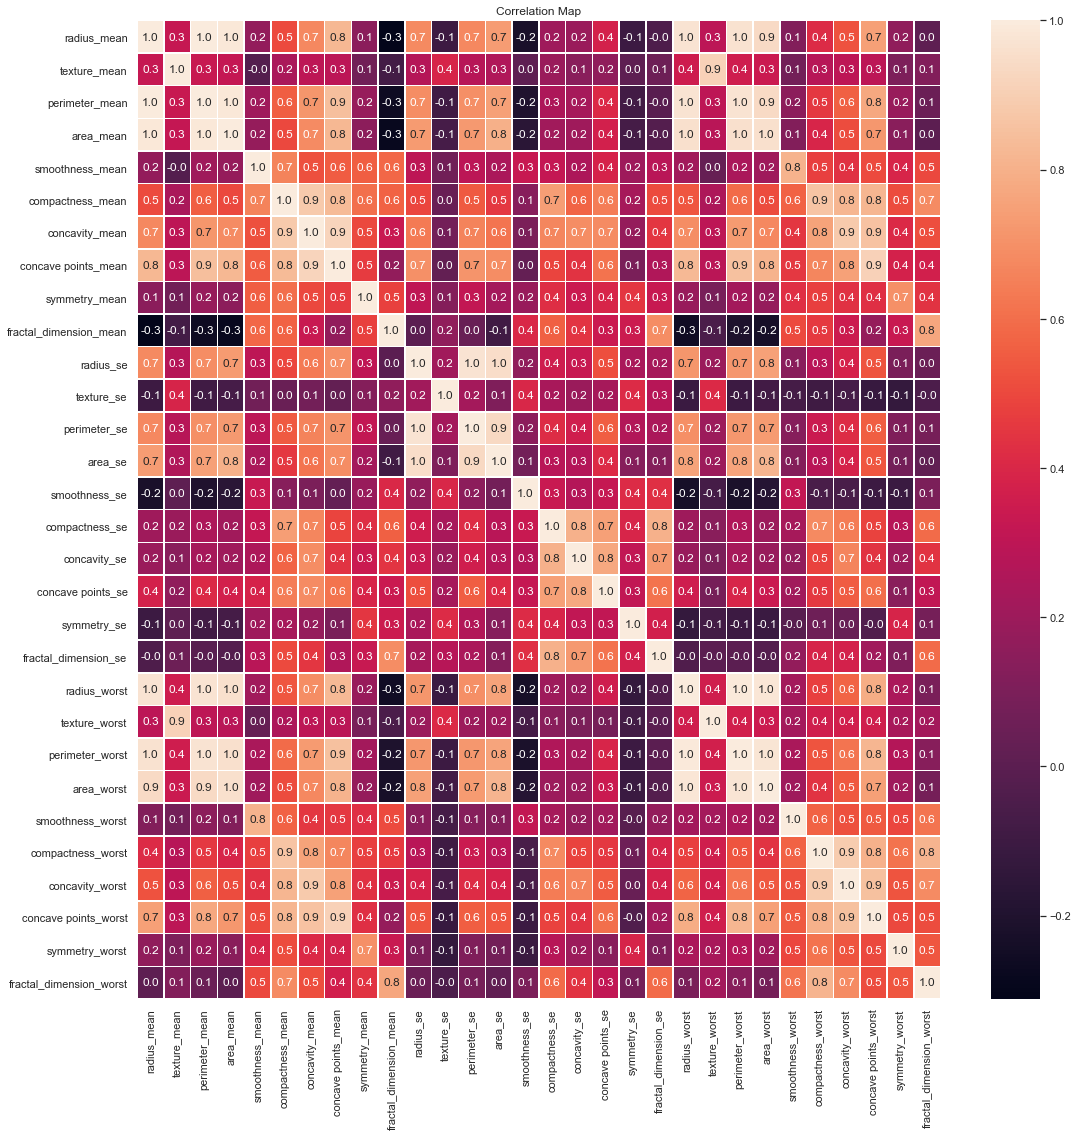

In [ ]:
f,ax=plt.subplots(figsize = (18,18))
sns.heatmap(data.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.savefig('graph.png')
plt.show()

* Matriks besar yang mencakup banyak angka
* Kisaran angka ini adalah -1 hingga 1. 
* Arti dari 1 adalah dua variabel yang saling berkorelasi positif seperti mean radius dan mean area
* Arti dari nol adalah tidak ada korelasi antara variabel seperti rata-rata radius dan fractal dimension se
* Arti dari -1 adalah dua variabel berkorelasi negatif satu sama lain seperti rata-rata radius dan mean/rata-rata fractal dimension.Sebenarnya korelasi antara keduanya bukan -1, melainkan -0,3 tetapi idenya adalah jika tanda korelasi negatif berarti ada adalah korelasi negatif.

<a id="9"></a> <br>
## Covariance
* Covariance adalah ukuran kecenderungan dua variabel untuk bervariasi bersama-sama
* Jadi covarians dimaksimalkan jika dua vektor identik
* Covarians adalah nol jika mereka ortogonal.
* Covariance negatif jika mereka menunjuk ke arah yang berlawanan
* Mari kita lihat kovarians antara mean radius dan mean area. Kemudian lihat radius mean dan fractal dimension se


In [18]:
cp.cov(data.radius_mean,data.area_mean)
print("Covariance diantara radius mean dan area mean: ",data.radius_mean.cov(data.area_mean))
print("Covariance diantara radius mean dan fractal dimension se: ",data.radius_mean.cov(data.fractal_dimension_se))

Covariance diantara radius mean dan area mean:  1224.4834093464567
Covariance diantara radius mean dan fractal dimension se:  -0.00039762485764406277


<a id="10"></a> <br>
## Pearson Correlation
* Pembagian covarians dengan standar deviasi variabel
* Mari kita lihat korelasi pearson antara mean/rata-rata radius dan mean/rata-rata area
* Pertama mari kita gunakan metode .corr() yang sebenarnya kita gunakan pada bagian korelasi. Di bagian korelasi kami sebenarnya menggunakan korelasi pearson :)
* p1 dan p2 adalah sama. Di p1 kita menggunakan metode corr(), di p2 kita menerapkan definisi korelasi pearson (cov(A,B)/(std(A)*std(B)))
* Seperti yang kita harapkan korelasi pearson antara area_mean dan area_mean adalah 1 yang berarti bahwa mereka adalah distribusi yang sama
* Juga pearson correlation antara area_mean dan radius_mean adalah 0,98 yang berarti saling berkorelasi positif dan hubungan antar keduanya sangat tinggi.
* Untuk lebih jelas apa yang kami lakukan di bagian korelasi dan bagian korelasi pearson adalah sama.


In [22]:
p1 = data.loc[:,["area_mean","radius_mean"]].corr(method= "pearson")
p2 = data.radius_mean.cov(data.area_mean)/(data.radius_mean.std()*data.area_mean.std())
print('Pearson correlation: ')
print(p1)
print('Pearson correlation: ',p2)

Pearson correlation: 
             area_mean  radius_mean
area_mean     1.000000     0.987357
radius_mean   0.987357     1.000000
Pearson correlation:  0.987357170056613


<a id="11"></a> <br>
## Spearman's Rank Correlation
* Pearson correlation bekerja dengan baik jika hubungan antara variabel linier dan variabel kira-kira normal. Tapi itu tidak kuat, jika ada outlier
* Untuk menghitung korelasi spearman, kita perlu menghitung peringkat dari setiap nilai


In [23]:
ranked_data = data.rank()
spearman_corr = ranked_data.loc[:,["area_mean","radius_mean"]].corr(method= "pearson")
print("Spearman's correlation: ")
print(spearman_corr)

Spearman's correlation: 
             area_mean  radius_mean
area_mean     1.000000     0.999602
radius_mean   0.999602     1.000000


* Korelasi Spearman sedikit lebih tinggi dari korelasi pearson
    * Jika hubungan antar distribusi tidak linier, korelasi spearman cenderung lebih baik dalam memperkirakan kekuatan hubungan
    * Korelasi Pearson dapat dipengaruhi oleh outlier. Sehingga Korelasi Spearman lebih kuat.

<a id="12"></a> <br>
## Mean VS Median
* Kadang-kadang sebagai gantinya mean kita perlu menggunakan median. Saya akan menjelaskan mengapa kita perlu menggunakan median dengan sebuah contoh
* Misalkan ada 10 orang yang bekerja di sebuah perusahaan. Bos perusahaan akan menaikkan gaji mereka jika mean/rata-rata gaji mereka lebih kecil dari 5


In [24]:
gaji = [1,4,3,2,5,4,2,3,1,500]
print("Mean/rata-rata dari gaji: ",cp.mean(gaji))

Mean/rata-rata dari gaji:  52.5


* Rata-rata gaji adalah 52,5 jadi bos berpikir bahwa oooo saya memberi banyak gaji kepada karyawan saya. Dan tidak membuat kenaikan gaji mereka. Namun seperti yang Anda tahu ini tidak adil dan 500 (gaji) adalah outlier untuk daftar gaji ini.
* Median menghindari outlier

In [25]:
print("Median dari gaji: ",cp.median(gaji))

Median dari gaji:  3.0


* Sekarang rata-rata gaji adalah 3 dan kurang dari 5 dan karyawan akan menaikkan gaji mereka dan mereka senang dan situasi ini adil :)

<a id="13"></a> <br>
## Hypothesis Testing
* Classical Hypothesis Testing / Pengujian Hipotesis Klasik
* Apa yang Anda perlu lakukan untuk menjawab pertanyaan berikut : "diberikan sampel dan efek nyata, berapa peluang melihat efek seperti itu secara kebetulan"
* Langkah pertama adalah mengukur ukuran efek nyata dengan memilih statistik uji. Pilihan alami untuk statistik uji adalah perbedaan mean/rata-rata antara dua kelompok.
* Langkah kedua adalah mendefinisikan hipotesis nol yaitu model sistem berdasarkan asumsi bahwa efek yang tampak tidak nyata. Hipotesis nol adalah jenis hipotesis yang digunakan dalam statistik yang menyatakan bahwa tidak ada signifikansi statistik dalam serangkaian pengamatan yang diberikan. Hipotesis nol adalah hipotesis yang orang mencoba untuk menyangkalnya. Hipotesis alternatif adalah hipotesis yang orang ingin mencoba untuk membuktikannya. 
* Langkah ketiga adalah menghitung p-value yaitu probabilitas melihat efek nyata jika hipotesis nol benar. Misalkan kita memiliki uji hipotesis nol. Kemudian kita hitung nilai p. Jika nilai p kurang dari atau sama dengan ambang batas, kami menolak hipotesis nol.
* Jika p-value rendah, pengaruh tersebut dikatakan signifikan secara statistik artinya tidak mungkin terjadi secara kebetulan. Oleh karena itu kita dapat mengatakan bahwa efeknya lebih mungkin muncul pada populasi yang lebih besar.
* Mari kita coba contohkan. Hipotesis nol: dunia rata. Hipotesis alternatif: dunia itu bulat. Beberapa ilmuwan mulai menyangkal hipotesis nol. Ini akhirnya mengarah pada refleksi hipotesis nol dan penerimaan hipotesis alternatif.
* Contoh lainnya. "efek ini nyata" ini adalah hipotesis nol. Berdasarkan asumsi itu kami menghitung probabilitas efek yang tampak. Itu adalah nilai-p. Jika nilai p rendah, kami menyimpulkan bahwa hipotesis nol tidak mungkin benar.
* Sekarang mari kita buat contoh kita:
    * Saya ingin mengetahui apakah rata-rata radius dan rata-rata area terkait satu sama lain? Hipotesis nol saya adalah bahwa "hubungan antara rata-rata radius dan rata-rata area adalah nol pada populasi tumor'.
    * Sekarang kita perlu menyangkal hipotesis nol ini untuk menunjukkan bahwa mean/rata-rata radius dan mean/rata-rata area berhubungan. (walaupun sebenarnya kita telah mengetahui hasilnya berdasarkan analisa korelasi yang telah dilakukan sebelumnya)
    * mari kita cari nilai p (nilai probabilitas)

In [26]:
statistic, p_value = stats.ttest_rel(data.radius_mean,data.area_mean)
print('p-value adalah: ',p_value)

p-value adalah:  1.5253492492559045e-184


* Hasil perhitungan P values/ Nilai P hampir mendekati nol, sehingga kita dapat menolak hipotesis nol. Penolakan hipotesis ini memiliki arti nilai rata-rata radius dan rata-rata area pada populasi tumor saling berpengaruh. 

<a id="14"></a> <br>
## Normal(Gaussian) Distribution and z-score
* Disebut juga distribusi berbentuk lonceng
* Daripada membuat definisi formal dari distribusi gaussian, saya ingin menjelaskannya dengan sebuah contoh.
* Contoh klasik adalah gaussian IQ Score/score iq.
     * Di dunia katakanlah IQ rata-rata adalah 110.
     * Ada beberapa orang yang super cerdas dan IQ mereka lebih tinggi dari 110. Bisa 140 atau 150 tapi jarang.
     * Juga ada beberapa orang yang memiliki kecerdasan rendah dan IQ mereka lebih rendah dari 110. Bisa 40 atau 50 tapi jarang.
     * Dari informasi ini kita dapat mengatakan bahwa rata-rata IQ adalah 110. Dan katakanlah standar deviasi adalah 20.
     * Rata-rata dan simpangan baku adalah parameter distribusi normal.
     * Mari kita buat 100000 sampel dan visualisasikan dengan histogram.


mean:  109.79634156093094
standart deviation:  20.02354424070161


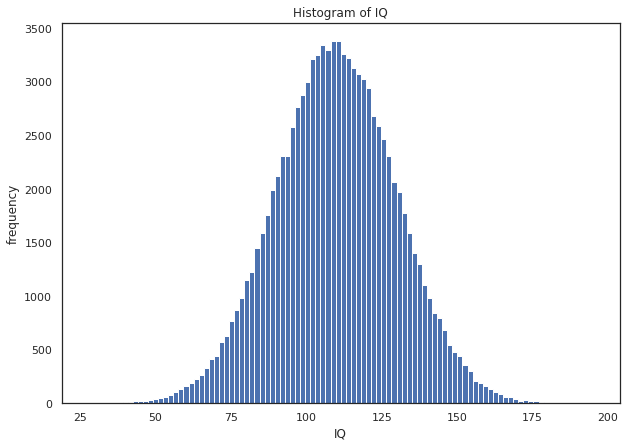

In [27]:
# parameters of normal distribution
mu, sigma = 110, 20  # mean and standard deviation
## membuat nilai random
s = cp.random.normal(mu, sigma, 100000)
print("mean: ", cp.mean(s))
print("standart deviation: ", cp.std(s))
# visualize with histogram
plt.figure(figsize = (10,7))
plt.hist(s, 100, density=False)
plt.ylabel("frequency")
plt.xlabel("IQ")
plt.title("Histogram of IQ")
plt.show()

* Seperti yang dapat dilihat dari histogram sebagian besar orang terakumulasi mendekati 110 yang merupakan rata-rata dari distribusi normal kita
* Namun apa yang "paling" yang saya sebutkan di kalimat sebelumnya? Bagaimana jika saya ingin tahu berapa persentase orang yang harus memiliki skor IQ antara 80 dan 140?
* Kami akan menggunakan z-score untuk menjawab pertanyaan ini.
     * z = (x - rata-rata)/std
     * z1 = (80-110)/20 = -1.5
     * z2 = (140-110)/20 = 1,5
     * Jarak antara mean dan 80 adalah 1,5std dan jarak antara mean dan 140 adalah 1,5std.
     * Jika Anda melihat tabel z, Anda akan melihat bahwa 1,5std sesuai dengan 0,4332
 <a href="https://ibb.co/hys6OT"><img src="https://preview.ibb.co/fYzWq8/123.png" alt="123" border="0"></a>
     
     
     * Mari kita hitung dengan 2 karena 1 dari 80 berarti dan lainnya dari rata-rata hingga 140
     * 0,4332 * 2 = 0,8664
     * 86.64% orang memiliki IQ antara 80 dan 140.
     
  <a href="https://ibb.co/fhc6OT"><img src="https://preview.ibb.co/bUi2xo/hist.png" alt="hist" border="0"></a>

Berapa persentase orang yang seharusnya memiliki skor IQ kurang dari 80?
* z = (110-80)/20 = 1,5
* Mari kita lihat tabel skor z 0,4332. 43,32% orang memiliki IQ antara 80 dan mean(110).
* Jika kita kurangi dari 50% menjadi 43,32%, kita dapat menemukan persentase orang yang memiliki skor IQ kurang dari 80.
* 50-43,32 = 6,68. Hasil dari, **6,68% orang memiliki skor IQ kurang dari 80.**

## Jawaban

1. Silahkan modifikasi kode operasi yang ada menggunakan library perhitungan berbasis GPU (Library Cupy)

### 2. Jelaskan apakah terdapat korelasi antara variabel atau fitur compactness_mean dengan concavity_mean

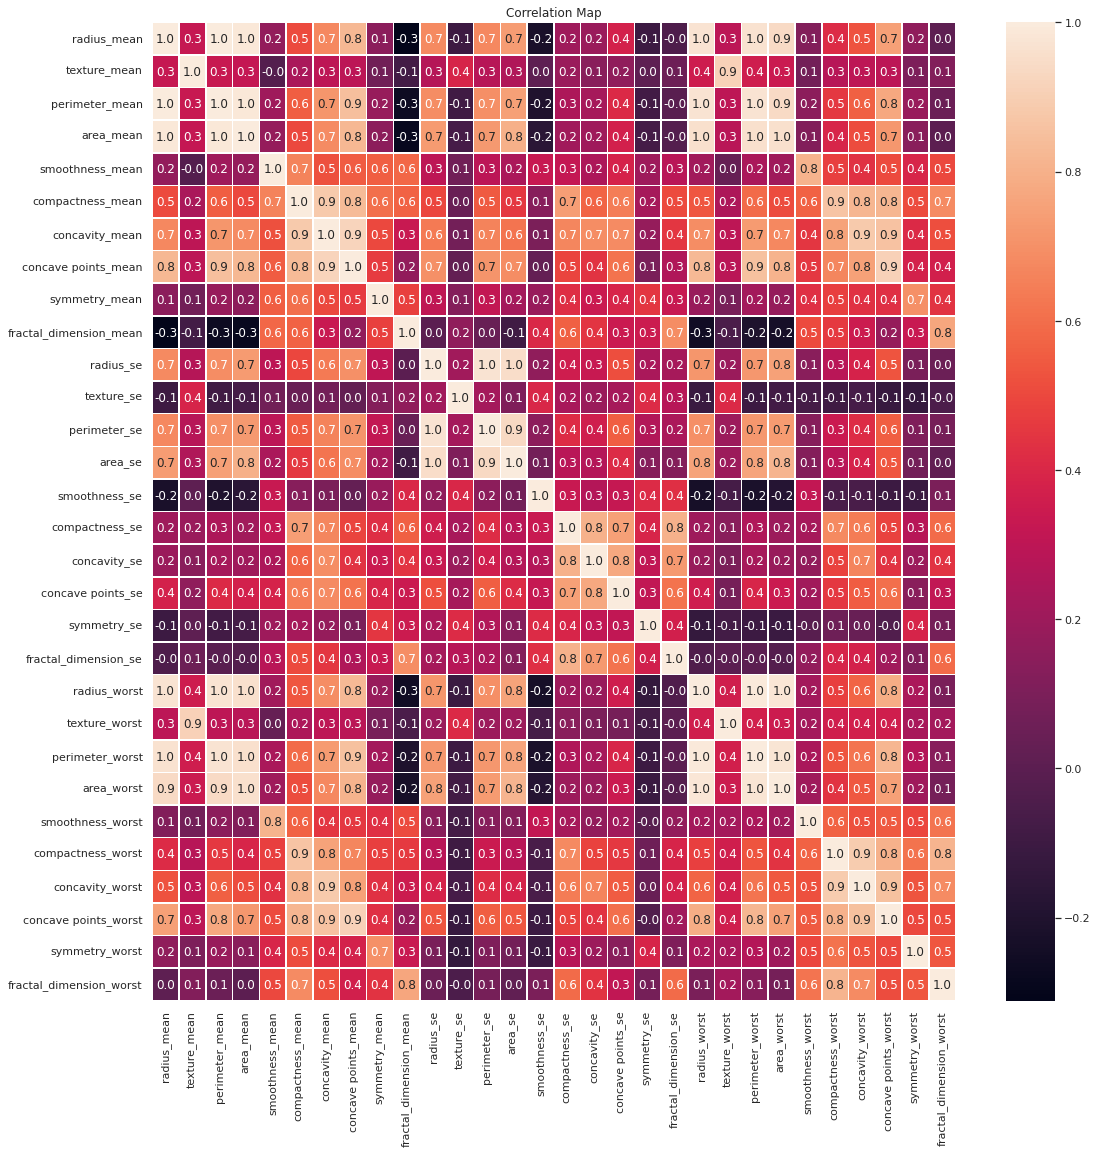

In [28]:
f,ax=plt.subplots(figsize = (18,18))
sns.heatmap(data.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.savefig('graph.png')
plt.show()

**iya, terdapat korelasi antara compactness_mean dengan concavity_mean, dikarenakan pada plot diatas, menghasilkan nilai 0.9 yang mana mendekati satu yang berarti berupa dua variabel yang saling berkorelasi positif.**

## 3. Buatlah diagram korelasi dari fitur compactness_mean dengan concavity_mean

<Figure size 1080x720 with 0 Axes>

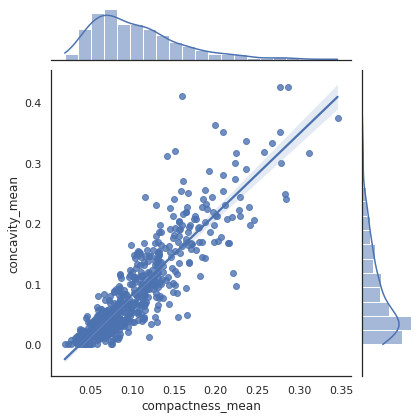

In [29]:
plt.figure(figsize = (15,10))
sns.jointplot(data.compactness_mean,data.concavity_mean,kind="reg")
plt.show()

### 4. Hitung nilai covariance dari fitur compactness_mean dengan concavity_mean. Jelaskan arti dari nilai tersebut.

In [30]:
cp.cov(data.compactness_mean,data.concavity_mean)
print("Covariance diantara compactness mean dan concavity mean: ",data.compactness_mean.cov(data.concavity_mean))

Covariance diantara compactness mean dan concavity mean:  0.003718134921780181


Covariance adalah ukuran kecenderungan dua variabel untuk bervariasi bersama-sama, jadi jika semakin membesar maka kedua variabel tersebut akan bervariasi bersama-sama. 
Namun jika mendekati nol, mereka ortogonal. 

### 5. Hitung nilai pearson correlation dari fitur compactness_mean dengan concavity_mean. Jelaskan arti dari nilai tersebut.

In [31]:
p1 = data.loc[:,["compactness_mean","concavity_mean"]].corr(method= "pearson")
p2 = data.compactness_mean.cov(data.concavity_mean)/(data.compactness_mean.std()*data.concavity_mean.std())
print('Pearson correlation: ')
print(p1)
print('Pearson correlation: ',p2)

Pearson correlation: 
                  compactness_mean  concavity_mean
compactness_mean          1.000000        0.883121
concavity_mean            0.883121        1.000000
Pearson correlation:  0.8831206701772506


**pearson correlation antara compactness_mean dan concavity_mean adalah 0,88 yang berarti saling berkorelasi positif dan hubungan antar keduanya cukup tinggi.**

### 6. Lakukan uji hipotesis untuk kolom fitur compactness_mean dengan concavity_mean yang berbeda serta berikan penjelasan terhadap hasil dari uji hipotesis yang dilakukan.

In [32]:
statistic, p_value = stats.ttest_rel(data.compactness_mean,data.concavity_mean)
print('p-value adalah: ',p_value)

p-value adalah:  4.29231315918515e-18


**Hipotesis nol adalah jenis hipotesis yang digunakan dalam statistik yang menyatakan bahwa tidak ada signifikansi statistik dalam serangkaian pengamatan yang diberikan. Hipotesis nol adalah hipotesis yang orang mencoba untuk menyangkalnya. Hipotesis alternatif adalah hipotesis yang orang ingin mencoba untuk membuktikannya.

Saya ingin mengetahui apakah rata-rata radius dan rata-rata area terkait satu sama lain? Hipotesis nol saya adalah bahwa "hubungan antara rata-rata compactness dan rata-rata concavity adalah nol pada populasi tumor'.
Hasil perhitungan P values/ Nilai P hampir mendekati nol, sehingga kita dapat menolak hipotesis nol. Penolakan hipotesis ini memiliki arti nilai rata-rata compactness dan rata-rata concavity pada populasi tumor saling berpengaruh.